# GW cosmography with standard sirens
## A mock analysis

In this notebook, we will perform the Bayesian analysis following the paper [The Hitchhiker's guide to the galaxy catalog approach for gravitational wave cosmology](https://arxiv.org/abs/2212.08694). Their approach is implemented here in the [`DrawnGWLikelihood` classes](./likelihood.py).

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import healpy as hp
from catalog.utils import GalaxyCatalog
from inference.likelihood import DrawnGWPerfectRedshiftLikelihood, DrawnGWFullLikelihood

### Generating the CBC events

We use the GLADE+ catalog for the redshift information. For the GW data, we make the assumption that the GW signals come from the galaxies within the catalog, and draw (at random) a value of $z$ corresponding to a particular galaxy in the catalog, up to $z_\text{max} < 1.4$, following the methodology in the paper.

In [13]:
filename = "./catalog/output.hdf5"
catalog = GalaxyCatalog(filename)

We draw a set of sky directions $\{(\theta_i, \varphi_i)\}$ and we consider circular patches with a fixed angular radius $\alpha$ for each of them, which we consider as the GW localisation area. We select all galaxies within each patch up to $z_\text{max}=1.4$, and we draw $N_{\text{GW}}$ events for each of them.

In [22]:
# Parameters
z_max = 1.4
n_dir = 2
n_gw_per_dir = 50
alpha = np.radians(2)

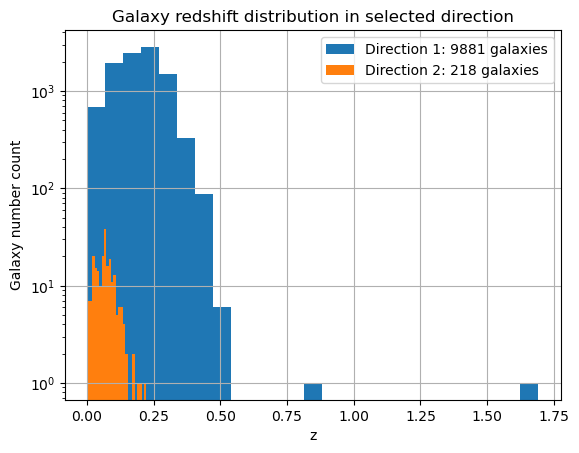

In [23]:
# Draw sky directions
theta = np.random.uniform(0, np.pi / 2, n_dir)
phi = np.random.uniform(0, 2 * np.pi, n_dir)
gw_loc_centers = np.array([hp.ang2vec(theta_i, phi_i) for theta_i, phi_i in zip(theta, phi)])

# Get corresponding HEALPIX pixels
ipix_within_gw_locs = [
    hp.query_disc(nside=catalog.nside, vec=center, radius=alpha)
    for center in gw_loc_centers
]

# Get corresponding galaxy redshifts
z_gal = [
    catalog.z_at_index(ipix_within_gw_loc)
    for ipix_within_gw_loc in ipix_within_gw_locs
]

for i, z_gal_in_dir in enumerate(z_gal):
    plt.hist(z_gal_in_dir, bins=25, log=True, label=f"Direction {i + 1}: {len(z_gal_in_dir)} galaxies")
plt.xlabel('z')
plt.ylabel('Galaxy number count')
plt.title('Galaxy redshift distribution in selected direction')
plt.legend()
plt.grid()
plt.show()

The mergers' redshifts are drawn from the galaxy catalog and are then converted to luminosity distance supposing a fiducial flat $\Lambda \text{CDM}$ cosmology, with $H_0 = 0.7 \, \rm{km} \, \rm{s}^{-1}\, \rm{Mpc}^{-1}$ and $\Omega_{m0} = 0.3$. For simplicity, we follow the reference paper by discarding events whose $d_L > d_L^{\text{thresold}} = 1550 \, \rm{Mpc}$.

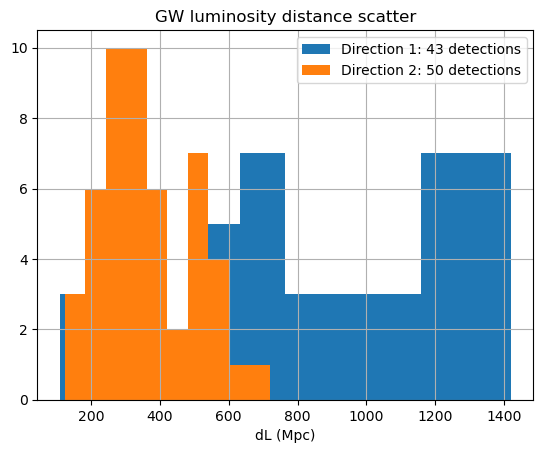

In [30]:
fiducial_H0 = 70.
lkh = DrawnGWPerfectRedshiftLikelihood(fiducial_H0=fiducial_H0)
gw_dl_array = [lkh.draw_gw_events(z_gal_i, n_gw_per_dir) for z_gal_i in z_gal]
for i, gw_dl in enumerate(gw_dl_array):
    plt.hist(gw_dl, label=f"Direction {i + 1}: {len(gw_dl)} detections")
plt.xlabel('dL (Mpc)')
plt.title('GW luminosity distance scatter')
plt.legend()
plt.grid()
plt.show()


### Simplification 1: negligible galaxy redshift uncertainty

In this section, we compute the posterior probability $p(H_0 | d_{\text{GW}}) \propto p(d_{\text{GW}} | H_0)p(H_0)$ under the assumption that the true galaxy redshifts are known (i.e that we made a perfect measurement). The single event likelihood becomes

\begin{equation}
p(d_i | H_0) = 
\frac{\sum_i^{N_\text{gal}} p(d_i | d_L(\hat{z}^i_\text{gal}, H_0))}{\sum_i^{N_\text{gal}} P^{\text{GW}}_{\text{det}}(\hat{z}^i_\text{gal}, H_0)}
\end{equation}

which corresponds to Eq. (15) of the paper.

We start by loading the catalog:

Below we plot the correction due to selection effects, which corresponds to the ratio between the expected detected number of events, $N_\text{det}$, and the total events, $N$. We see that, for high $H_0$, the fraction of events that are actually detected tends to 0.

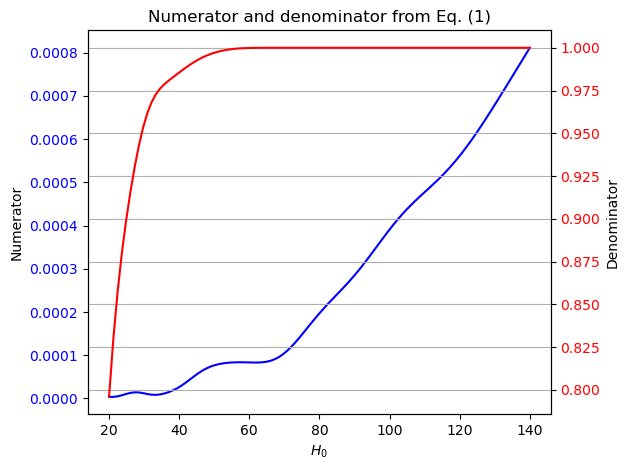

In [25]:
n_H0 = 100
H0_array = np.linspace(20., 140., n_H0)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(H0_array, lkh.gw_likelihood_array(gw_dl_array[1][2], H0_array, z_gal[0]), color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2.plot(H0_array, lkh.selection_effects(H0_array, z_gal[1]), color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.title('Numerator and denominator from Eq. (1)')
ax1.set_xlabel(r'$H_0$')
ax1.set_ylabel('Numerator')
ax2.set_ylabel('Denominator')
fig.tight_layout()
plt.grid()
plt.show()

Building the likelihood:

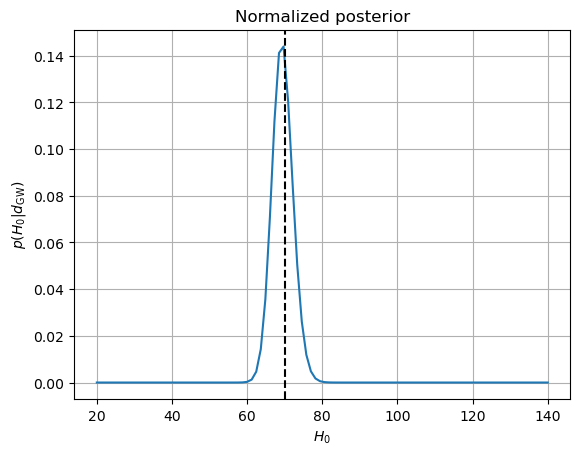

In [26]:
likelihood, matrix = lkh.likelihood(gw_dl_array, H0_array, z_gal, n_dir=n_dir)
plt.plot(H0_array, likelihood)
plt.axvline(fiducial_H0, ls='--', c='k')
plt.grid()
plt.title("Normalized posterior")
plt.xlabel(r"$H_0$")
plt.ylabel(r"$p(H_0 | d_\text{GW})$")
plt.show()

### Incorporating galaxy redshift uncertainty into the analysis

In this section, we take into account the fact that the galaxy redshift measurement is not perfect. Because of this, the integration over the galaxies' true redshifts is no longer trivial - delta functions are replace by a gaussian PDF - and the full expression for the posterior becomes Eq. (29) in the paper.

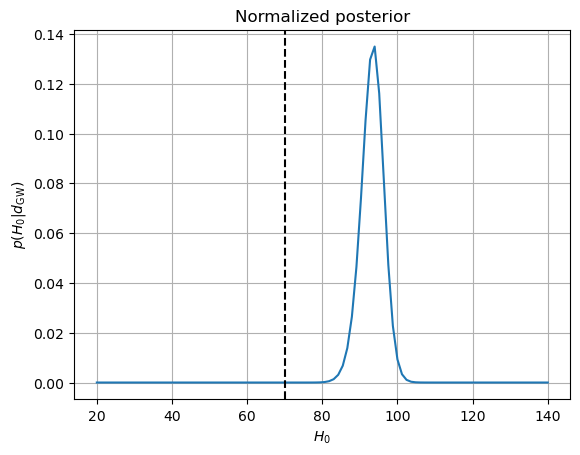

In [27]:
n_z = 100
z_min = min([np.min(z_gal_i) for z_gal_i in z_gal])
z = np.linspace(z_min, z_max, n_z)
full_likelihood, _ = DrawnGWFullLikelihood(fiducial_H0=fiducial_H0).likelihood(gw_dl_array, H0_array, z, z_gal, n_dir=n_dir)
plt.plot(H0_array, full_likelihood)
plt.axvline(fiducial_H0, ls='--', c='k')
plt.grid()
plt.title("Normalized posterior")
plt.xlabel(r"$H_0$")
plt.ylabel(r"$p(H_0 | d_\text{GW})$")
plt.show()